In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [23]:
df = pd.read_csv("iar_ocupaciones.csv")
df = df.drop_duplicates()
df['Fecha_hoy'] = pd.to_datetime(df['Fecha_hoy'])
df = df[df['moneda_cve'] != 1]

In [24]:
# Dataframe for numerical columns and date
df_num = df[['Fecha_hoy', 'ing_hab']]
df_num['daily'] = df['Fecha_hoy'].dt.strftime('%Y-%m-%d')
df_num = df_num.drop("Fecha_hoy", axis=1)
df_num.head()

/var/folders/jh/wqv8k9v13k7_v10t9h68wrbh0000gn/T/ipykernel_49833/3287129472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['daily'] = df['Fecha_hoy'].dt.strftime('%Y-%m-%d')


,ing_hab,daily
0,0.000000,2021-11-15
1,0.000000,2021-11-15
3,0.000000,2021-11-15
4,0.000000,2021-11-15
7,142.833688,2021-11-15


In [25]:
df_num = df_num.groupby(by="daily").agg({
    'ing_hab': 'sum'
})
df_num.reset_index(inplace=True)
df_num.rename(columns={'daily': 'ds', 'ing_hab': 'y'}, inplace=True)
df_num

,ds,y
0,2020-11-01,41455.424522
1,2020-11-02,38801.379988
2,2020-11-03,36662.744539
3,2020-11-04,28582.579950
4,2020-11-05,41455.420104
...,...,...
1516,2024-12-27,309938.684978
1517,2024-12-28,311207.656497
1518,2024-12-29,316687.648674
1519,2024-12-30,350222.348831


03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/jh/wqv8k9v13k7_v10t9h68wrbh0000gn/T/ipykernel_49833/578610937.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


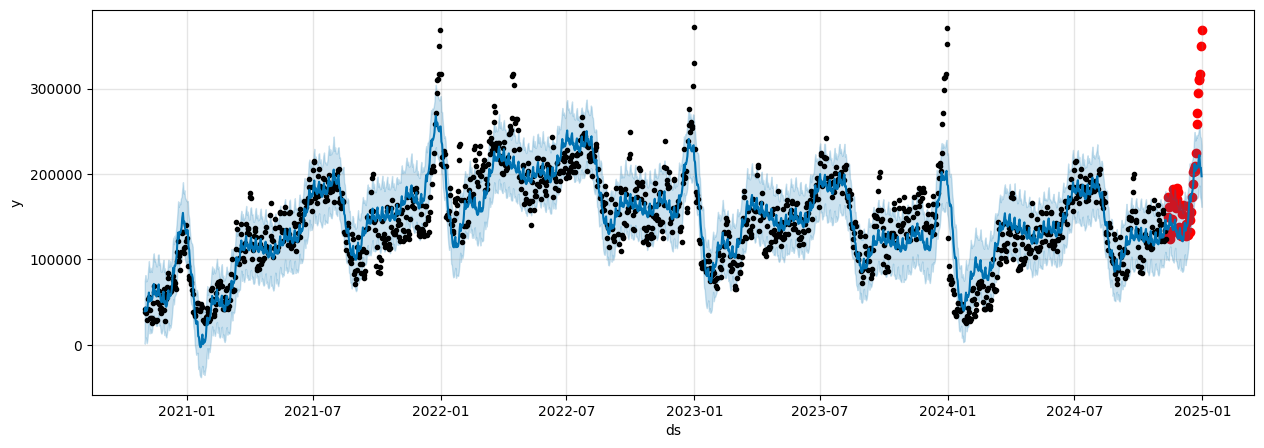

In [83]:
testing_cycles = 1
# Split the data into train and test; tenemos 27 ciclos
train_size = (int(len(df_num)//30) - testing_cycles)*30
train, test = df_num[0:train_size], df_num[train_size:len(df_num)]
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
f, ax = plt.subplots(figsize=(15,5))
test['ds'] = pd.to_datetime(test['ds'])
ax.scatter(test["ds"],test["y"],color="r")

fig1 = m.plot(forecast,ax=ax)
#fig2 = m.plot_components(forecast)


Root Mean Squared Error (RMSE) - M1: 48112.12519171528
Mean Absolute Percent Error - M1: 0.1525366401503935


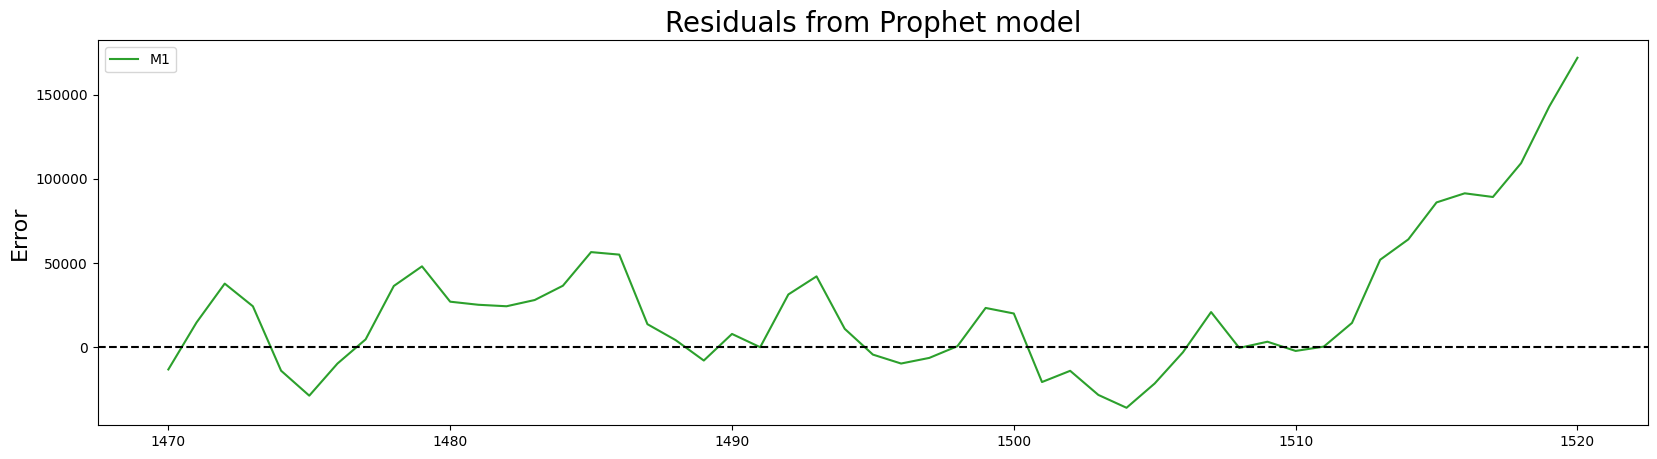

In [84]:
residuals1 = test['y'] - forecast['yhat'][-(len(test)):]
rmse1 = mean_squared_error(test['y'], forecast['yhat'][-(len(test)):])**0.5

#Plot config
font_name = "Serif"

plt.figure(figsize=(20,5))
plt.plot(residuals1, label='M1', color='tab:green')
#defining the ideal residual baseline
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from Prophet model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.legend(loc='best')

print('Root Mean Squared Error (RMSE) - M1:', rmse1)
print('Mean Absolute Percent Error - M1:', round(np.mean(abs(residuals1/test['y'])),len(residuals1)))